# Project \#4: Find the “Largest” Digit

## Part 1 : Data preprocessing

### Imports

In [1]:
%matplotlib inline

In [2]:
import pandas, numpy as np
import matplotlib.pyplot as plt

### Read Data to Numpy

In [3]:
!ls ./Datasets

sample_x.csv  sample_y.csv  test_x.csv	train_x.csv  train_y.csv


In [4]:
!head -n 20 Datasets/train_x.csv > Datasets/sample_x.csv
!head -n 20 Datasets/train_y.csv > Datasets/sample_y.csv

In [5]:
x = np.loadtxt("Datasets/sample_x.csv", delimiter=",") # load from text 
y = np.loadtxt("Datasets/sample_y.csv", delimiter=",") 
x = x.reshape(-1, 64, 64) # reshape 
y = y.reshape(-1, 1) 

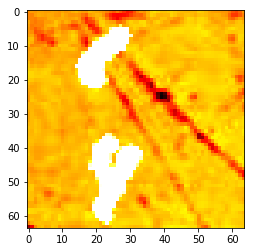

In [6]:
plt.imshow(x[0], cmap='hot', interpolation='nearest')

### Filtering and Grouping Black Pixels

### Goal :
Identify all the pixels of value 255 (ie the handwritten digits), group these pixels together so each handwritten digit is in its own self-contained group. Then we can compare the sizing of each grouping to identify the largest digit in the image.

### Implementations :

__Filtering for all dark pixels : __ Floor divide all pixel values by threshold value (BLACK_THRES) resulting in everything below that threshold goes to 0 then get the coordinates of the nonzero values. (Assumption : the background doesn't contain pixels above the threshold value)

__Grouping with Coordinates : __ Takes the coordinates of handwritten pixels in form [(x1,y1),(x2,y2),...]. Iterate points and subtract each point's coordinates from all points in each group (ie gives ~distance from current point to each point in the group), if the shortest distance from the current point to some point in the group is less than a threshold value (PIX_DISTANCE) then these points are considered to belong to the same hand written digit so add the current point to that group and repeat. If the point doesn't have neighbours create a new group for it. If the point has neighbours in 2 groups combine those groups together cuz they're probably different parts of the same digit. Return the groups => [[ptsInGroup1], [ptsInGroup2], ...] => [[(x1,y1),(x2,y2),...], [(x3,y3),(x4,y4),...],[...]]


In [9]:
PIX_DISTANCE = 4
def groupPoints(binCoords):
    groups = []
    for pt in binCoords:
        # distances = array of distances from each group for the current point
        distances = np.array([
            np.absolute(np.subtract(grp, pt)).sum(axis=1).min()
            for grp in groups
        ])
        
        # which of these currentPt<-->group distances are within the grouping threshold
        withInPixDist = np.where(distances < PIX_DISTANCE)[0]
        if(len(withInPixDist)==0):
            # no groups are within pixel distance
            groups.append([pt])
        else:
            groups[np.argmin(distances)].append(pt)
            # handle grouping groups
            if len(withInPixDist) > 1:
                # current point joins 2 groups
                groups[withInPixDist[0]] = groups[withInPixDist[0]] + groups[withInPixDist[1]]
    return groups

In [10]:
# returns coordinates of min, max points of given group.
def getBounds(group):
    mins = np.min(group, axis=0)
    maxs = np.max(group, axis=0)
    return {
        'x' : (mins[1], maxs[1], maxs[1] - mins[1]),
        'y' : (mins[0], maxs[0], maxs[0] - mins[0])
    }

In [11]:
BLACK_THRES = 255.0

def preprocessImage(img):
    
    # Filter just dark colors
    binX = np.floor_divide(img, BLACK_THRES)
    
    # group and get bounds of hand written digits
    binCoords = zip(*np.nonzero(binX))
    groups = groupPoints(binCoords)
    bounds = [getBounds(group) for group in groups]
    
    # return largest image
    indLargetImg = np.argmax([max(bound['x'][2], bound['y'][2]) for bound in bounds])
    sliceBounds = bounds[indLargetImg]
    imgSlice = img[sliceBounds['y'][0]:sliceBounds['y'][1], sliceBounds['x'][0]:sliceBounds['x'][1]]
    return np.floor_divide(imgSlice, BLACK_THRES)

#### Testing & Visualize Grouping Implementation

In [12]:
tmp = preprocessImage(x[0])

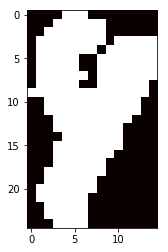

In [13]:
plt.imshow(tmp, cmap='hot', interpolation='nearest')

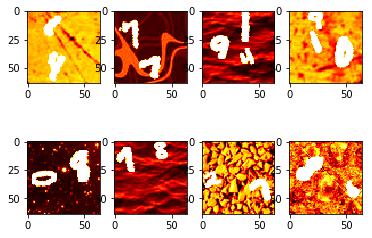

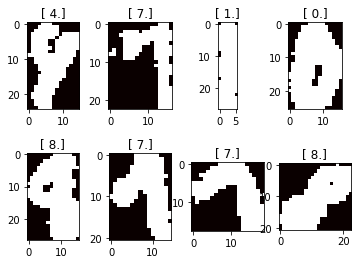

In [14]:
f, axarr = plt.subplots(2, 4)
f.subplots_adjust(hspace=0.5)
axarr[0][0].imshow(x[0], cmap='hot', interpolation='nearest')
axarr[0][1].imshow(x[1], cmap='hot', interpolation='nearest')
axarr[0][2].imshow(x[2], cmap='hot', interpolation='nearest')
axarr[0][3].imshow(x[3], cmap='hot', interpolation='nearest')
axarr[1][0].imshow(x[4], cmap='hot', interpolation='nearest')
axarr[1][1].imshow(x[5], cmap='hot', interpolation='nearest')
axarr[1][2].imshow(x[6], cmap='hot', interpolation='nearest')
axarr[1][3].imshow(x[7], cmap='hot', interpolation='nearest')

f, axarr = plt.subplots(2, 4)
f.subplots_adjust(hspace=0.5)
axarr[0][0].set_title(y[0])
axarr[0][0].imshow(preprocessImage(x[0]), cmap='hot', interpolation='nearest')
axarr[0][1].set_title(y[1])
axarr[0][1].imshow(preprocessImage(x[1]), cmap='hot', interpolation='nearest')
axarr[0][2].set_title(y[2])
axarr[0][2].imshow(preprocessImage(x[2]), cmap='hot', interpolation='nearest')
axarr[0][3].set_title(y[3])
axarr[0][3].imshow(preprocessImage(x[3]), cmap='hot', interpolation='nearest')
axarr[1][0].set_title(y[4])
axarr[1][0].imshow(preprocessImage(x[4]), cmap='hot', interpolation='nearest')
axarr[1][1].set_title(y[5])
axarr[1][1].imshow(preprocessImage(x[5]), cmap='hot', interpolation='nearest')
axarr[1][2].set_title(y[6])
axarr[1][2].imshow(preprocessImage(x[6]), cmap='hot', interpolation='nearest')
axarr[1][3].set_title(y[7])
axarr[1][3].imshow(preprocessImage(x[7]), cmap='hot', interpolation='nearest')

In [15]:
imgSlice = preprocessImage(x[0])

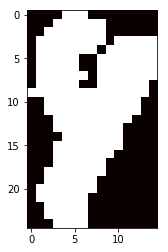

In [16]:
plt.imshow(imgSlice, cmap='hot', interpolation='nearest')

### Reshape handwritten digits into standard shape

### Goal :
The extracted images of individual handwritten digits will be of different sizes. Neural Networks require consistent input data shape inorder to work effectively, so we must standardize the shape of these images.

### Implementations :

__Centering the digit : __ Given img of digit and target shape will return image of target shape with the img of digit centered with black background.

__Stretch to fit digit : __ Stretches a given image into the target shape by evenly duplicating/droping rows and columns in the original img of the digit provided until it meets the required shape.

__Scale to fit digit : __ Scales the img of digit (using the same techniques as above) such that the img perfectly fits within the target shape specified.


#### Implemenation of Centering Digit

In [17]:
# places an image slice centered inside a target shape and returns the full image
# params : (2d np array)
# crashes if targetShape is smaller than image
def cropCenter(img, targetShape):
    img = getImgCenter(img, (min(img.shape[0], targetShape[0]), min(img.shape[1], targetShape[1])))
    imgFinal = np.zeros(targetShape)
    imgFinalCenter = getImgCenter(imgFinal, img.shape)
    imgFinalCenter[:,:] = img
    return imgFinal

In [18]:
# given an image (2d np array) 
# params : (2d-np-array, (target_height, target_width))
def getImgCenter(img, targetShape):
    halfSlice = (img.shape[0]//2, img.shape[1]//2)
    halfTarg = (targetShape[0]//2, targetShape[1]//2)
    
    bottomBnd = (halfSlice[0] - (halfTarg[0]), halfSlice[1] - (halfTarg[1]))
    topBnd = (halfSlice[0] + (targetShape[0]-halfTarg[0]), halfSlice[1] + (targetShape[1]-halfTarg[1]))
    return img[bottomBnd[0]:topBnd[0], bottomBnd[1]:topBnd[1]]

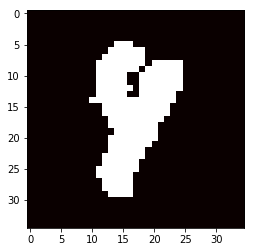

In [19]:
plt.imshow(cropCenter(imgSlice, (35,35)), cmap='hot', interpolation='nearest')

#### Implemenation of Stretch to Fit

In [21]:
def randStretchCenter(img, targetShape):
    tmpImg = stretchArr(img, targetShape[0])
    tmpImg = stretchArr(tmpImg.T, targetShape[1])
    return tmpImg.T
    
def stretchArr(array, targetLength):
    if targetLength == len(array):
        return array
    
    # inds is even distribution of n indecies along the array. n is the difference between target and current
    inds = np.floor(np.arange(0.05,len(array),len(array)/float(abs(targetLength - len(array))))).astype(int)
    if targetLength > len(array):
        # target larger than array.. ie duplicate some rows to fit size
        dupRows = array[inds]
        return np.insert(array, inds, dupRows, axis=0)
    else:
        # target smaller than array.. remove rand elements from array
        return np.delete(array, inds, axis=0)

(15, 15)


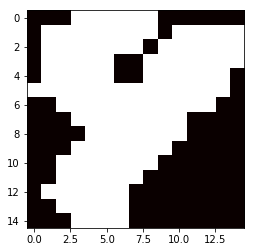

In [22]:
tmp = randStretchCenter(imgSlice, (15,15))
print tmp.shape
plt.imshow(tmp, cmap='hot', interpolation='nearest')

#### Implemenation of Scaling to fit

In [23]:
def scaledStretch(img, targetShape):
    scale0 = float(targetShape[0])/img.shape[0]
    scale1 = float(targetShape[1])/img.shape[1]
    #print img.shape, targetShape, (scale0, scale1)
    scaledImg = stretchArr(img, min(scale0, scale1)*img.shape[0])
    scaledImg = stretchArr(scaledImg.T, min(scale0, scale1)*img.shape[1]).T
    
    imgFinal = np.zeros(targetShape)
    imgFinalCenter = getImgCenter(imgFinal, scaledImg.shape)
    imgFinalCenter[:,:] = scaledImg
    
    return imgFinal

(25, 15) (40, 40) (1.6, 2.6666666666666665)
(40, 40)


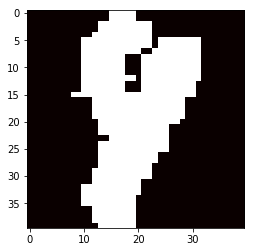

In [24]:
tmp = scaledStretch(imgSlice, (40,40))
print tmp.shape
plt.imshow(tmp, cmap='hot', interpolation='nearest')

In [1]:
# returns array of 2d matrices (of the target size) of the largest digit in each photo
def readAndPreprocess(filename, targetShape):
    x = np.loadtxt(filename, delimiter=",") # load from text 
    x = x.reshape(-1, 64, 64) # reshape 
    data = []
    for row in x:
        imgSlice = preprocessImage(row)
        data.append(scaledStretch(imgSlice, targetShape))
    return np.array(data)